In [ ]:
# EnPI 예측 모델
%load_ext tensorboard

import pathlib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import shutil
import functools
import pandas as pd 
import seaborn as sbn 
from tensorflow import keras
import datetime, os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Read csv data from the file and creat a dataset
#csv data file path
data = "pca_7"
data_path = "/content/drive/MyDrive/EnPI/동은단조/합계처리/"+data+"_train.csv"

data_size = 287
train_output = "energy"

#Define a read csv filee
def get_dataset(file_path, **kwargs):
    dataset = tf.data.experimental.make_csv_dataset(
        file_path,
        batch_size = data_size,
        label_name = train_output,
        na_value = "?",
        ignore_errors = True,
        **kwargs)
    return dataset

column_name = ['pca1', 'pca2',	'pca3',	'pca4', 'pca5',	'pca6',	'pca7', 'energy']
DEFAULTS = [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00]      #type of the column data
raw_data_train = get_dataset(data_path,
                            select_columns = column_name,
                            column_defaults = DEFAULTS)

#Define a show_batch function to see the dataset
#this funcion is not necessary for programe
def show_batch(dataset):
    for batch, label in dataset.take(1):
        for key, value in batch.items():
            print("{:20s}: {}".format(key, value.numpy()))

#show_batch(raw_data_train)            

#Processing data befor feeding into model
#funcion pack together all the column
def pack(feartures, label): 
    return tf.stack(list(feartures.values()), axis = -1), label

packed_dataset = raw_data_train.map(pack)    
for feartures, labels in packed_dataset.take(1):
    None

# Slit data into test, eval and predict
eval_size = 60    # 10%
predict_size = 0
train_size = data_size - eval_size - predict_size   #remain data is training

train_x, eval_x, predict_x = feartures[:train_size,:], feartures[train_size:train_size+eval_size,:], feartures[train_size+eval_size:,:]
train_y, eval_y, predict_y = labels[:train_size], labels[train_size:train_size+eval_size], labels[data_size-predict_size:]

## 데이터 정규화
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
"""
scaler = MinMaxScaler()
scaler.fit(train_x)
train_x = scaler.transform(train_x)
eval_x = scaler.transform(eval_x)
#predict_x = scaler.transform(predict_x)
"""
#import joblib
#file_name = '발전기전기자_scaler(10).pkl'
#scaler = joblib.load(file_name)

##inspect data using seaborn

data_x_array = np.array(train_x)
data_y_array = np.array(train_y).reshape(len(train_y),1)
data_xy_array = np.concatenate((data_x_array,data_y_array), axis =1)
header = ['pca1', 'pca2',	'pca3',	'pca4', 'pca5',	'pca6',	'pca7', 'energy']
dataframe = pd.DataFrame(data_xy_array, columns= header)
print(dataframe)
column= dataframe.shape[1]

         pca1      pca2      pca3      pca4      pca5      pca6      pca7  \
0   -0.396300  0.808691  0.160873  0.377986 -0.262941  0.256659 -0.043742   
1    0.214046  0.080912  0.082139 -0.310344 -0.389806 -0.069507  0.048019   
2    1.272269 -0.413748  0.343492  0.091587 -0.084996  0.037366  0.056149   
3    0.583072  0.199614 -0.245825 -0.103142  0.177747 -0.085154  0.061924   
4   -0.796615 -0.136365 -0.069963 -0.008241 -0.062912 -0.252056 -0.154219   
..        ...       ...       ...       ...       ...       ...       ...   
222 -0.343385  0.087127 -0.194121 -0.404899  0.159748  0.018912  0.057899   
223 -0.155200  0.060710 -0.127089 -0.300841  0.235618 -0.045193  0.105036   
224 -0.072211 -0.611893  0.020459  0.401322  0.027060  0.094264  0.225689   
225 -0.523997  0.245186  0.080872  0.344336  0.136171  0.467501 -0.055482   
226  0.074017  0.009734 -0.452770 -0.032526  0.476658  0.109739  0.076483   

          energy  
0    1177.767944  
1     870.755310  
2      34.780800  

In [ ]:
#Define ANN model and training method
input_node = column-1
hid1_node = 16 #// 노드 갯수를 올렸을 때 이전과 같으면 더이상 증가 ㄴㄴ
hid2_node = 32
hid3_node = 64
hid4_node = 32
hid5_node = 16
output_node = 1
initializer = tf.keras.initializers.HeNormal()
#regularizer=tf.keras.regularizers.l2()

def build_model():
    return tf.keras.Sequential([
        tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation = 'relu', input_shape = (input_node,1)),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(hid1_node, activation = 'relu', input_shape = (input_node,)),
        #tf.keras.layers.Dense(hid2_node, activation = 'relu', kernel_initializer=initializer),
        #tf.keras.layers.Dense(hid3_node, activation = 'relu'),
        #tf.keras.layers.Dense(hid4_node, activation = 'relu'),
        #tf.keras.layers.Dense(hid5_node, activation = 'relu'),
        tf.keras.layers.Dense(output_node, activation='softplus')
    ])

model = build_model()
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics = ['mae', 'mape'])


#Check the network model, weights
model.summary()

Epochs = 150 #// train 주기횟수
log_dir = os.path.join("logs",
                        "fit",
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq =1)

batch_fit = 2 #//100 이하로 설정
verbose_fit = 1 #//verbose 1일시 학습상황 확인가능

history = model.fit(train_x, train_y,
                    validation_data = (eval_x, eval_y),
                    epochs = Epochs,
                    batch_size = batch_fit,
                    verbose = verbose_fit,)

#Save the trained model

model.save('/content/drive/MyDrive/EnPI/동은단조/합계처리/결과/'+data+'.h5')

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_35 (Conv1D)          (None, 6, 64)             192       
                                                                 
 max_pooling1d_35 (MaxPoolin  (None, 3, 64)            0         
 g1D)                                                            
                                                                 
 flatten_35 (Flatten)        (None, 192)               0         
                                                                 
 dense_97 (Dense)            (None, 16)                3088      
                                                                 
 dense_98 (Dense)            (None, 1)                 17        
                                                                 
Total params: 3,297
Trainable params: 3,297
Non-trainable params: 0
___________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


114/114 [==============================] - 1s 6ms/step - loss: 956627.2500 - mae: 926.0354 - mape: 99.0771 - val_loss: 1031354.7500 - val_mae: 977.5110 - val_mape: 97.8887
Epoch 2/150
114/114 [==============================] - 0s 4ms/step - loss: 870768.4375 - mae: 879.2823 - mape: 91.2915 - val_loss: 838998.9375 - val_mae: 877.3034 - val_mape: 91.8433
Epoch 3/150
114/114 [==============================] - 0s 4ms/step - loss: 592163.1875 - mae: 718.0532 - mape: 92.9406 - val_loss: 449711.2188 - val_mae: 625.9514 - val_mape: 80.7637
Epoch 4/150
114/114 [==============================] - 0s 4ms/step - loss: 261231.1875 - mae: 463.0224 - mape: 106.3622 - val_loss: 156265.5312 - val_mae: 340.2819 - val_mape: 71.7480
Epoch 5/150
114/114 [==============================] - 0s 4ms/step - loss: 120462.9531 - mae: 287.1055 - mape: 125.4849 - val_loss: 85787.2734 - val_mae: 246.4956 - val_mape: 75.3528
Epoch 6/150
114/114 [==============================] - 0s 4ms/step - loss: 99705.7109 - mae: 24

8


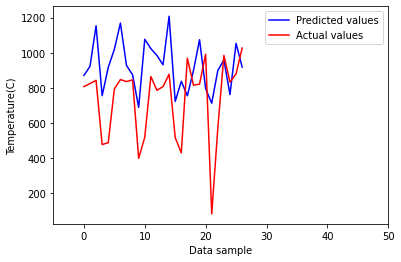

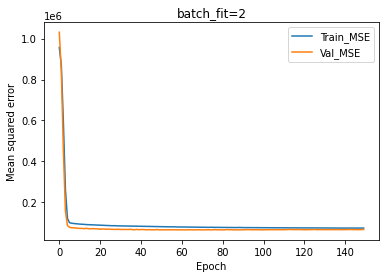

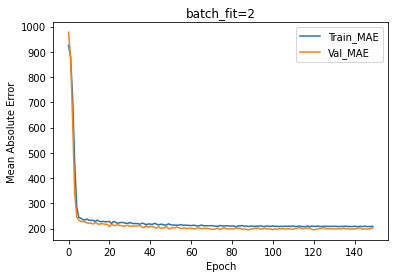

[60.3406863]


In [ ]:
#Load the trained model
data_path = "/content/drive/MyDrive/EnPI/동은단조/합계처리/"+data+"_test.csv"
#print('total')
dfs = pd.read_csv(data_path)
columns= dfs.shape[1]
predict_size= dfs.shape[0]
print(columns)
#print(rows)
data_path=np.array(dfs)
#predict_size=12
predict_x = data_path[:predict_size,0:columns-1]
predict_y = data_path[:predict_size,columns-1:columns]
#predict_x = scaler.transform(predict_x)


predict_output = model.predict(predict_x)
real_predict_array = np.array(predict_y).reshape(predict_size,1)
predictor_error = abs(predict_output - real_predict_array)
predictor_error2 = abs(predict_output - real_predict_array)/real_predict_array
MAE = sum(predictor_error)/len(predictor_error)
MAPE = sum(predictor_error2)/len(predictor_error2)*100

#Save weight and bias matrix to csv file
import numpy

plt.plot(predict_output,'b-', label='Predicted values')
plt.plot(predict_y,'r-', label='Actual values')
plt.xlabel('Data sample')
plt.ylabel('Temperature(C)')
plt.legend(loc='upper right')
#plt.ylim(-5, 119)
plt.xlim(-5, 50)
plt.show()
#check the data
#mse, mae = model.evaluate(eval_x, eval_y, verbose = 2)

#결과저장
import csv
np.set_printoptions(suppress=True)
with open('/content/drive/MyDrive/EnPI/동은단조/합계처리/결과/'+data+'_test.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Predicted power", "Actual power", "error", "MAE", "MAPE"])
    writer.writerow(["", "", "", MAE[0], MAPE[0]])
    for i in range(len(predict_output)):
        writer.writerow([predict_output[i][0], real_predict_array[i][0], predictor_error[i][0]])
    
#plot resutls
plt.plot(history.history['loss'], label = 'Train_MSE')
plt.plot(history.history['val_loss'], label = 'Val_MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean squared error')
plt.title('batch_fit='+str(batch_fit))
plt.legend(loc='upper right')
plt.show()

plt.plot(history.history['mae'], label = 'Train_MAE')
plt.plot(history.history['val_mae'], label = 'Val_MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.title('batch_fit='+str(batch_fit))
plt.legend(loc='upper right')
plt.show()

print(MAPE)
